This notebook assembles aggregated biometric time-series for the key metrics across Short and Long formats, aligning long-form key moments to their short-form counterparts. The workflow mirrors the styling and structure of `analysis_self-report.ipynb` while leveraging reusable helpers from `wbdlib`.

## Notebook Roadmap
1. Configuration and path setup
2. Data inputs and validation
3. Processing helpers (windowing, binning, smoothing)
4. Per-respondent extraction and caching
5. Aggregation to cohort-level time series
6. Visualisation (Short vs Long overlays)
7. Diagnostics and logging

In [1]:
from pathlib import Path
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import wbdlib
import wbdlib.timeseries as _wbd_ts
importlib.reload(_wbd_ts)
importlib.reload(wbdlib)

from wbdlib import (
    COLOR_MAP,
    aggregate_binned_time_series,
    build_stimulus_lookup,
    canonicalise_title,
    default_metric_columns,
    default_time_series_processing_config,
    load_key_moments,
    load_stimulus_map,
    process_sensor_time_series,
 )
from wbdlib.plotting import register_boxplot_with_means

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["font.family"] = "Century Gothic"
plt.rcParams["figure.figsize"] = [10, 4]
plt.rcParams.update({"font.size": 10, "axes.titleweight": "bold"})
register_boxplot_with_means()

PALETTE = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
DEFAULT_FIGSIZE = (10, 4)
NOTEBOOK_ROOT = Path.cwd()

# Paths
PROJECT_ROOT = NOTEBOOK_ROOT.parent
DATA_EXPORT_DIR = PROJECT_ROOT / "data" / "Export"
CACHE_DIR = PROJECT_ROOT / "results" / "time_series_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

### Extraction and aggregation implementation

The following cell will:
- Build an index of sensor CSV paths under `data/Export`
- Load `uv_stage1`, `stimulus_rename.csv`, and `key_moments.csv`,
- Call `wbdlib.process_sensor_time_series` per respondent to extract, bin, and smooth metric segments, and
- Cache per-title binned series plus diagnostics to `results/time_series_cache/`.

Run this cell locally (it streams large CSVs).

In [2]:
# Load mapping and key moments
stimulus_map = load_stimulus_map(PROJECT_ROOT / "data" / "stimulus_rename.csv")
stimulus_lookup = build_stimulus_lookup(stimulus_map)
key_moment_table = load_key_moments(PROJECT_ROOT / "data" / "key_moments.csv")

processing_config = default_time_series_processing_config()
metric_columns = default_metric_columns()

# Build sensor filename -> path lookup
sensor_paths = list(DATA_EXPORT_DIR.glob("Group */Analyses/*/Sensor Data/*.csv"))
sensor_lookup = {p.name: p for p in sensor_paths}
print(f"Found {len(sensor_paths)} sensor CSV files under data/Export")

# Load respondent roster (if available)
uv_stage1_path = PROJECT_ROOT / "results" / "uv_stage1.csv"
if uv_stage1_path.exists():
    uv_stage1 = pd.read_csv(uv_stage1_path)
else:
    uv_stage1 = pd.DataFrame(columns=["respondent", "group", "source_file"])
    print("Warning: uv_stage1.csv not found; no respondent roster loaded")

binned_frames = []
diagnostic_frames = []
issue_records = []
metadata_records = []

# Iterate respondents (optionally limit for testing)
N_MAX = None  # set to an int while testing to limit number of respondents
count_proc = 0

for _, resp in uv_stage1.iterrows():
    if N_MAX and count_proc >= N_MAX:
        break
    respondent_id = resp.get("respondent")
    group = resp.get("group")
    source_file = resp.get("source_file")

    sensor_path = None
    if isinstance(source_file, str) and source_file in sensor_lookup:
        sensor_path = sensor_lookup[source_file]
    else:
        pattern = str(respondent_id).strip()
        if pattern:
            matches = [
                path
                for name, path in sensor_lookup.items()
                if pattern in name
            ]
            if matches:
                sensor_path = matches[0]

    if sensor_path is None:
        issue_records.append(f"{respondent_id}: no sensor CSV located")
        continue

    try:
        result = process_sensor_time_series(
            sensor_path,
            respondent_id=respondent_id,
            group=group,
            stimulus_lookup=stimulus_lookup,
            stimulus_map=stimulus_map,
            key_moment_table=key_moment_table,
            metric_columns=metric_columns,
            processing_config=processing_config,
        )
    except Exception as exc:
        issue_records.append(
            f"{respondent_id}: failed to process '{sensor_path.name}' ({exc})"
        )
        continue

    if not result.binned.empty:
        binned_copy = result.binned.copy()
        binned_copy["source_path"] = str(sensor_path)
        binned_frames.append(binned_copy)

    if not result.diagnostics.empty:
        diag_copy = result.diagnostics.copy()
        diag_copy["source_path"] = str(sensor_path)
        diagnostic_frames.append(diag_copy)

    if result.metadata:
        meta_record = {
            "respondent_id": respondent_id,
            "source_path": str(sensor_path),
        }
        meta_record.update(result.metadata)
        metadata_records.append(meta_record)

    if result.issues:
        issue_records.extend(result.issues)

    count_proc += 1

if binned_frames:
    binned_df = pd.concat(binned_frames, ignore_index=True)
    binned_path = CACHE_DIR / "binned_per_respondent.parquet"
    binned_df.to_parquet(binned_path, index=False)
    print(f"Wrote {len(binned_df):,} binned rows to {binned_path}")
else:
    binned_df = pd.DataFrame()
    print("No respondent bins generated.")

if diagnostic_frames:
    diagnostics_df = pd.concat(diagnostic_frames, ignore_index=True)
    diagnostics_path = CACHE_DIR / "binned_per_respondent_diagnostics.csv"
    diagnostics_df.to_csv(diagnostics_path, index=False)
    print(f"Wrote respondent diagnostics to {diagnostics_path}")
else:
    diagnostics_df = pd.DataFrame()
    print("No diagnostics generated.")

if metadata_records:
    sensor_metadata_df = pd.DataFrame(metadata_records)
    metadata_path = CACHE_DIR / "sensor_metadata.csv"
    sensor_metadata_df.to_csv(metadata_path, index=False)
    print(f"Captured sensor metadata in {metadata_path}")
else:
    sensor_metadata_df = pd.DataFrame()

if issue_records:
    issues_df = pd.DataFrame({"issue": issue_records})
    issues_path = CACHE_DIR / "processing_issues.csv"
    issues_df.to_csv(issues_path, index=False)
    print(f"Logged {len(issue_records)} processing issues to {issues_path}")
else:
    issues_df = pd.DataFrame(columns=["issue"])
    print("No processing issues captured.")

print(f"Processed {count_proc} respondents with available sensor files.")

Found 83 sensor CSV files under data/Export


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\analysis\wbdlib\imotions.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=header_rows, **csv_kwargs)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\analysis\wbdlib\imotions.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=header_rows, **csv_kwargs)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\analysis\wbdlib\imotions.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, header=header_rows, **csv_kwargs)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\analysis\wbdlib\imotions.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(

Wrote 1,582,874 binned rows to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\binned_per_respondent.parquet


PermissionError: [Errno 13] Permission denied: 'c:\\Users\\ashra\\Documents\\NeuralSense\\NeuralData\\clients\\544_WBD_CXCU\\results\\time_series_cache\\binned_per_respondent_diagnostics.csv'

### Cohort-level aggregation
Once respondent bins are cached, aggregate them into cohort-level summaries, compute contributor counts, and persist the results for plotting and QA.

In [3]:
# Aggregate respondent bins into cohort-level series
binned_cache_path = CACHE_DIR / "binned_per_respondent.parquet"
if ("binned_df" not in globals()) or binned_df.empty:
    if binned_cache_path.exists():
        binned_df = pd.read_parquet(binned_cache_path)
        print(f"Loaded {len(binned_df):,} cached respondent bins from {binned_cache_path}")
    else:
        binned_df = pd.DataFrame()
        print("No respondent bins available for aggregation.")
if binned_df.empty:
    aggregated_df = pd.DataFrame()
    aggregated_all_df = pd.DataFrame()
    summary_df = pd.DataFrame()
    print("Skipping aggregation because no bins are present.")
else:
    aggregated_df = aggregate_binned_time_series(binned_df)
    if aggregated_df.empty:
        aggregated_all_df = pd.DataFrame()
        summary_df = pd.DataFrame()
        print("Aggregation produced no bins after coverage filtering; check respondent diagnostics for gaps.")
    else:
        aggregated_path = CACHE_DIR / "aggregated_time_series.parquet"
        aggregated_csv_path = CACHE_DIR / "aggregated_time_series.csv"
        aggregated_df.to_parquet(aggregated_path, index=False)
        aggregated_df.to_csv(aggregated_csv_path, index=False)
        print(f"Wrote {len(aggregated_df):,} aggregated bins to {aggregated_path}")
        aggregated_all_df = aggregate_binned_time_series(
            binned_df.assign(group="All Groups")
)
        aggregated_all_path = CACHE_DIR / "aggregated_time_series_all_groups.parquet"
        aggregated_all_csv_path = CACHE_DIR / "aggregated_time_series_all_groups.csv"
        aggregated_all_df.to_parquet(aggregated_all_path, index=False)
        aggregated_all_df.to_csv(aggregated_all_csv_path, index=False)
        print(
            f"Wrote {len(aggregated_all_df):,} aggregated bins across all groups to {aggregated_all_path}"
)
        summary_group_cols = ["title", "form", "sensor", "metric"]
        summary_df = (
            aggregated_df.groupby(summary_group_cols, dropna=False)
            .agg(
                bins=("bin", "nunique"),
                avg_contributors=("contributors", "mean"),
                min_contributors=("contributors", "min"),
                max_contributors=("contributors", "max"),
            )
            .reset_index()
        )
        summary_df["avg_contributors"] = summary_df["avg_contributors"].round(2)
        groups_present = (
            aggregated_df.groupby(summary_group_cols, dropna=False)["group"]
            .nunique()
            .reset_index(name="groups_present")
        )
        total_contributors = (
            binned_df.loc[binned_df["passes_coverage"].astype(bool)]
            .groupby(summary_group_cols, dropna=False)["respondent_id"]
            .nunique()
            .reset_index(name="total_unique_contributors")
        )
        summary_df = (
            summary_df
            .merge(groups_present, on=summary_group_cols, how="left")
            .merge(total_contributors, on=summary_group_cols, how="left")
        )
        column_order = summary_group_cols + [
            "bins",
            "avg_contributors",
            "min_contributors",
            "max_contributors",
            "groups_present",
            "total_unique_contributors",
        ]
        summary_df = summary_df[column_order]
        summary_path = CACHE_DIR / "aggregated_time_series_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(
            "Saved aggregation summary with contributor ranges and unique respondent counts to"
            f" {summary_path}"
        )

Wrote 127,033 aggregated bins to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\aggregated_time_series.parquet
Wrote 60,898 aggregated bins across all groups to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\aggregated_time_series_all_groups.parquet
Wrote 60,898 aggregated bins across all groups to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\aggregated_time_series_all_groups.parquet
Saved aggregation summary with contributor ranges and unique respondent counts to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\aggregated_time_series_summary.csv
Saved aggregation summary with contributor ranges and unique respondent counts to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\aggregated_time_series_summary.csv


### Visualisation (Short vs Long overlays)
Leverage the aggregated cohort series to render Short/Long overlays with the same styling conventions used in `wbdlib.plotting`, including font choices, visible spines, and light gridlines.

In [9]:
def apply_timeseries_axes_style(ax, *, title=None, ylabel=None, xlabel="Time (s)", xmax=None):
    """Mirror plotting.py axis styling with visible spines and light grids."""
    if title:
        ax.set_title(title)
    if xmax is not None and np.isfinite(xmax):
        ax.set_xlim(0.0, float(xmax))
    else:
        current_left, current_right = ax.get_xlim()
        right = current_right if np.isfinite(current_right) else 0.0
        ax.set_xlim(0.0, max(right, 0.0))
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color("#222")
        ax.spines[spine].set_linewidth(1.2)
    ax.tick_params(axis="both", labelcolor="#222")
    ax.figure.subplots_adjust(bottom=0.22, right=0.95)
    return ax


def plot_time_series_overlay(
    aggregated: pd.DataFrame,
    *,
    title: str,
    sensor: str,
    metric: str,
    smoothing_label: str | None = None,
    use_smoothed: bool = True,
    ax=None,
):
    """Render Short/Long overlays with wbdlib.plotting-inspired formatting."""
    if aggregated is None or aggregated.empty:
        print("Aggregation frame is empty; nothing to plot.")
        return None

    canonical_title = canonicalise_title(title)
    subset = aggregated.loc[
        (aggregated["title"] == canonical_title)
        & (aggregated["sensor"] == sensor)
        & (aggregated["metric"] == metric)
    ].copy()

    if subset.empty:
        print(
            f"No bins found for title='{title}', sensor='{sensor}', metric='{metric}'."
        )
        return None

    available_labels = subset["smoothing_label"].dropna().unique()
    if smoothing_label:
        if smoothing_label not in available_labels:
            label_list = ", ".join(sorted(map(str, available_labels))) or "none"
            print(
                f"Smoothing label '{smoothing_label}' not available. Expected one of: {label_list}."
            )
            return None
        subset = subset.loc[subset["smoothing_label"] == smoothing_label].copy()
    else:
        if available_labels.size:
            dominant_label = (
                subset["smoothing_label"].dropna().value_counts().idxmax()
            )
            subset = subset.loc[subset["smoothing_label"] == dominant_label].copy()
            smoothing_label = dominant_label

    if subset.empty:
        print("Requested smoothing selection returned no bins.")
        return None

    value_column = (
        "mean_smoothed"
        if use_smoothed and "mean_smoothed" in subset.columns
        else "mean_value"
    )
    lower_column = (
        "ci95_low_smoothed"
        if value_column == "mean_smoothed"
        else "ci95_low"
    )
    upper_column = (
        "ci95_high_smoothed"
        if value_column == "mean_smoothed"
        else "ci95_high"
    )

    if ax is None:
        _, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

    plotted = 0
    for form in ["Short", "Long"]:
        form_slice = subset.loc[subset["form"] == form].sort_values("bin")
        if form_slice.empty:
            continue
        color = PALETTE.get(form, "#4c72b0")
        contributors = (
            int(form_slice["contributors"].max())
            if form_slice["contributors"].notna().any()
            else 0
        )
        ax.plot(
            form_slice["bin_midpoint"],
            form_slice[value_column],
            label=f"{form} (n={contributors})",
            color=color,
            linewidth=2.0,
        )
        if (
            lower_column in form_slice
            and upper_column in form_slice
            and form_slice[lower_column].notna().any()
            and form_slice[upper_column].notna().any()
        ):
            ax.fill_between(
                form_slice["bin_midpoint"],
                form_slice[lower_column],
                form_slice[upper_column],
                color=color,
                alpha=0.2,
                linewidth=0,
            )
        plotted += 1

    if plotted == 0:
        print("No Short/Long form bins available for the requested selection.")
        return None

    overlay_title = f"{title} · {sensor} · {metric}"

    max_time = None
    if "bin_end" in subset.columns and subset["bin_end"].notna().any():
        max_time = subset["bin_end"].max()
    elif "bin_midpoint" in subset.columns and subset["bin_midpoint"].notna().any():
        max_time = subset["bin_midpoint"].max()
    if pd.notna(max_time):
        max_time = float(max_time)
    else:
        max_time = None

    apply_timeseries_axes_style(
        ax,
        title=overlay_title,
        ylabel=metric,
        xlabel="Time (s)",
        xmax=max_time,
    )
    ax.legend(frameon=False, loc="upper left", ncol=1)
    return ax

,title,sensor,metric,smoothing_label,forms_present
0,A Star Is Born,EEG,Distraction,moving_average_window3,1
1,A Star Is Born,EEG,Drowsy,moving_average_window3,1
2,A Star Is Born,EEG,Frontal Alpha Asymmetry,moving_average_window3,1
3,A Star Is Born,EEG,High Engagement,moving_average_window3,1
4,A Star Is Born,EEG,Low Engagement,moving_average_window3,1
5,A Star Is Born,EEG,Workload Average,butterworth_lowpass_0.06Hz,1
6,A Star Is Born,ET,Blink Detected,NaN,1
7,A Star Is Born,ET,Fixation Dispersion,NaN,1
8,A Star Is Born,ET,Fixation Duration,NaN,1
9,A Star Is Born,ET,Fixation Index,NaN,1


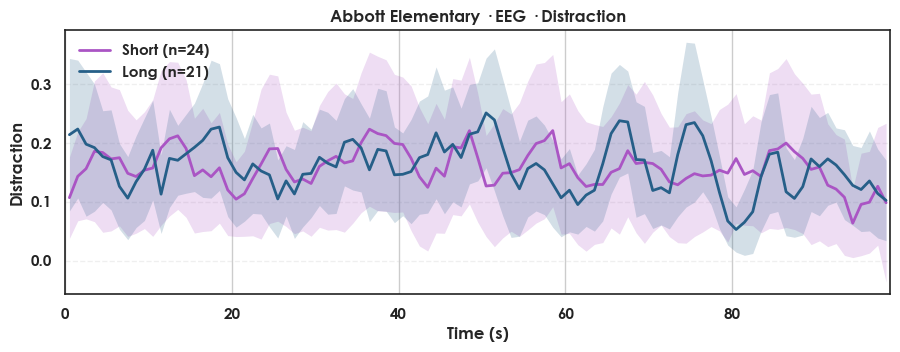

In [10]:
# Preview available aggregated combinations and render a sample overlay
aggregated_cache_path = CACHE_DIR / "aggregated_time_series.parquet"
aggregated_all_cache_path = CACHE_DIR / "aggregated_time_series_all_groups.parquet"
if ("aggregated_df" not in globals()) or aggregated_df.empty:
    if aggregated_cache_path.exists():
        aggregated_df = pd.read_parquet(aggregated_cache_path)
        print(
            f"Loaded {len(aggregated_df):,} aggregated bins (by group) from {aggregated_cache_path}"
        )
    else:
        aggregated_df = pd.DataFrame()
        print("Aggregated cache missing; run the aggregation cell first.")
if ("aggregated_all_df" not in globals()) or aggregated_all_df.empty:
    if aggregated_all_cache_path.exists():
        aggregated_all_df = pd.read_parquet(aggregated_all_cache_path)
        print(
            f"Loaded {len(aggregated_all_df):,} aggregated bins (all groups) from {aggregated_all_cache_path}"
        )
    else:
        aggregated_all_df = pd.DataFrame()
        if aggregated_df.empty:
            print("Aggregated all-groups cache missing; run the aggregation cell first.")
if aggregated_all_df.empty:
    print("No aggregated all-group data available for plotting.")
    available_combos = pd.DataFrame()
else:
    combo_columns = ["title", "sensor", "metric", "smoothing_label"]
    available_combos = (
        aggregated_all_df.groupby(combo_columns, dropna=False)["form"]
        .nunique()
        .reset_index(name="forms_present")
        .sort_values(combo_columns)
    )
    display(available_combos.head(10))
    candidate_rows = available_combos.loc[available_combos["forms_present"] >= 2]
    if candidate_rows.empty:
        candidate_rows = available_combos
    if not candidate_rows.empty:
        example_config = candidate_rows.iloc[0]
        label_arg = (
            example_config["smoothing_label"]
            if pd.notna(example_config["smoothing_label"])
            else None
        )
        _ = plot_time_series_overlay(
            aggregated_all_df,
            title=example_config["title"],
            sensor=example_config["sensor"],
            metric=example_config["metric"],
            smoothing_label=label_arg,
        )
    else:
        print("No form combinations found to plot.")

### Batch plot export
Generate overlays for every title/sensor/metric combination to a reusable cache of PNGs. Two-form combinations (Short and Long) are required; other combinations are skipped.

In [11]:
# Export overlays for all two-form combinations
PLOTS_DIR = CACHE_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
if aggregated_all_df.empty:
    print("No aggregated all-group data to plot; run the aggregation cells first.")
else:
    combo_columns = ["title", "sensor", "metric", "smoothing_label"]
    plot_combos = (
        aggregated_all_df.groupby(combo_columns, dropna=False)["form"]
        .nunique()
        .reset_index(name="forms_present")
    )
    plot_combos = plot_combos.loc[plot_combos["forms_present"] >= 2]
    if plot_combos.empty:
        print("No Short/Long combinations available for plotting.")
    else:
        generated = 0
        skipped = 0
        for _, combo in plot_combos.iterrows():
            smoothing_value = combo["smoothing_label"]
            label_arg = smoothing_value if pd.notna(smoothing_value) else None
            ax = plot_time_series_overlay(
                aggregated_all_df,
                title=combo["title"],
                sensor=combo["sensor"],
                metric=combo["metric"],
                smoothing_label=label_arg,
            )
            if ax is None:
                skipped += 1
                continue
            fig = ax.get_figure()
            parts = [combo["title"], combo["sensor"], combo["metric"]]
            if label_arg:
                parts.append(str(label_arg))
            slug_parts = []
            for part in parts:
                cleaned = "".join(
                    ch if ch.isalnum() or ch in ("-", "_") else "-"
                    for ch in str(part).lower()
                ).strip("-_")
                slug_parts.append(cleaned or "na")
            filename = "_".join(slug_parts) + ".png"
            output_path = PLOTS_DIR / filename
            fig.savefig(output_path, dpi=200, bbox_inches="tight")
            plt.close(fig)
            generated += 1
        print(f"Generated {generated} plot(s) to {PLOTS_DIR}")
        if skipped:
            print(f"Skipped {skipped} combination(s) due to missing data.")

Generated 69 plot(s) to c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\results\time_series_cache\plots
